In [1]:
import os
import ssl
import random
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from fedlab.utils.dataset.partition import MNISTPartitioner
from torchvision.datasets.utils import download_and_extract_archive

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"{device} is available")

mps is available


In [3]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

In [4]:
dataset_path = os.path.join("path_to_data")
ssl._create_default_https_context = ssl._create_unverified_context

# Override the MNIST resources URLs
class PatchedMNIST(torchvision.datasets.MNIST):
    resources = [
                ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
                ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
                ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
                ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
            ]
    
    @property
    def raw_folder(self):
        return os.path.join(self.root, "MNIST", "raw")
    
    @property
    def processed_folder(self):
        return os.path.join(self.root, "MNIST", "processed")

    def download(self):
        if self._check_exists():
            return
        
        os.makedirs(self.raw_folder, exist_ok=True)
        
        for url, md5 in self.resources:
            filename = os.path.basename(url)
            download_and_extract_archive(url, download_root=self.raw_folder, filename=filename, md5=md5)


trainset = PatchedMNIST(
    root=dataset_path, train=True, download=True, transform=transform
)
testset = PatchedMNIST(
    root=dataset_path, train=False, download=True, transform=transform
)

In [5]:
num_clients = 100
seed = 2021
alpha_values = [0.1, 0.3, 1.0, 5.0, 10.0]

partitions = {}
for alpha in alpha_values:
    partitions[f"Dirichlet_alpha_{alpha}"] = MNISTPartitioner(
        trainset.targets,
        num_clients=num_clients,
        partition="noniid-labeldir",
        dir_alpha=alpha,
        seed=seed,
    )

In [6]:
# Define Model (Simple CNN)
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 14 * 14, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
def train_on_worker(model, dataloader, device="cpu"):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Ensure the output and labels batch sizes match
        assert outputs.size(0) == labels.size(
            0
        ), f"Output batch size mismatch: {outputs.size(0)} vs {labels.size(0)}"

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    return {k: v.clone() for k, v in model.state_dict().items()}

In [8]:
def aggregate_updates(updates):
    return {
        k: torch.mean(torch.stack([u[k] for u in updates]), dim=0) for k in updates[0]
    }


def full_trim(update, fraction):
    for key, param in update.items():
        k = int(param.numel() * fraction)
        flat = param.view(-1)
        flat[torch.topk(flat.abs(), k=k, largest=False).indices] = 0
        param.copy_(flat.view_as(param))
    return update

In [9]:
def evaluate_model(model, dataloader, device="cpu"):
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

In [10]:
attack_fraction = 0.4
results = []
Epochs = 15
epoch_results = {alpha: {"Normal": [], "Attack": []} for alpha in alpha_values}

for alpha, partition in partitions.items():
    print(f"Running simulations for {alpha}...")
    client_indices = partition.client_dict
    workers = {
        i: DataLoader(Subset(trainset, indices), batch_size=32, shuffle=True)
        for i, indices in client_indices.items()
    }
    test_loader = DataLoader(testset, batch_size=32, shuffle=False)

    normal_accuracies = []
    attack_accuracies = []

    for attack in [False, True]:
        mode = "Attack" if attack else "No Attack"
        print(f"  Running mode: {mode}")
        model = SimpleCNN()
        epoch_accuracies = []

        for _ in range(Epochs):
            updates = []
            for i, loader in workers.items():
                local_update = train_on_worker(model, loader, device)
                if attack and random.random() < attack_fraction:
                    local_update = full_trim(local_update, 0.6)
                updates.append(local_update)

            aggregated_update = aggregate_updates(updates)
            model.load_state_dict(aggregated_update)
            accE = evaluate_model(model, test_loader, device)
            epoch_accuracies.append(accE)

        acc = evaluate_model(model, test_loader, device)
        print(f"    Accuracy: {acc:.4f}")
        alpha_value = alpha if isinstance(alpha, float) else alpha.split("_")[2]
        if attack:
            attack_accuracies.append(acc)
            epoch_results[float(alpha_value)]["Attack"] = epoch_accuracies
        else:
            normal_accuracies.append(acc)
            epoch_results[float(alpha_value)]["Normal"] = epoch_accuracies

    alpha_value = alpha if isinstance(alpha, float) else alpha.split("_")[2]
    results.append(
        {
            "Alpha": alpha_value,
            "Normal Accuracy": np.mean(normal_accuracies),
            "Attack Accuracy": np.mean(attack_accuracies),
        }
    )

Running simulations for Dirichlet_alpha_0.1...
  Running mode: No Attack
    Accuracy: 95.7400
  Running mode: Attack
    Accuracy: 93.6600
Running simulations for Dirichlet_alpha_0.3...
  Running mode: No Attack
    Accuracy: 96.8300
  Running mode: Attack
    Accuracy: 96.0700
Running simulations for Dirichlet_alpha_1.0...
  Running mode: No Attack
    Accuracy: 97.3100
  Running mode: Attack
    Accuracy: 96.7800
Running simulations for Dirichlet_alpha_5.0...
  Running mode: No Attack
    Accuracy: 97.6400
  Running mode: Attack
    Accuracy: 97.1400
Running simulations for Dirichlet_alpha_10.0...
  Running mode: No Attack
    Accuracy: 97.6200
  Running mode: Attack
    Accuracy: 97.2800


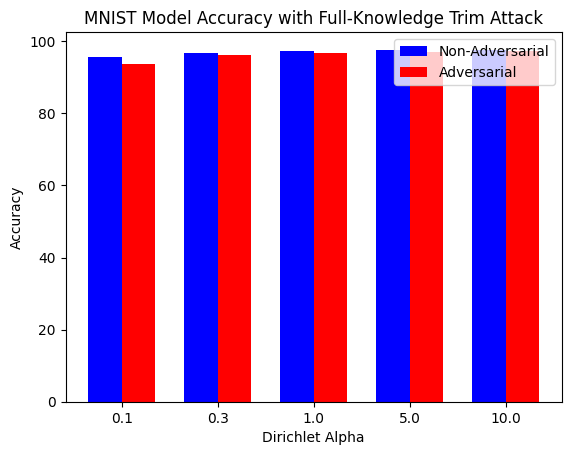

In [11]:
results_df = pd.DataFrame(results)

bar_width = 0.35
alphas_str = results_df["Alpha"].astype(str)
positions = np.arange(len(alphas_str))

plt.bar(
    positions - bar_width / 2,
    results_df["Normal Accuracy"],
    bar_width,
    label="Non-Adversarial",
    color="b",
)
plt.bar(
    positions + bar_width / 2,
    results_df["Attack Accuracy"],
    bar_width,
    label="Adversarial",
    color="r",
)

plt.xlabel("Dirichlet Alpha")
plt.ylabel("Accuracy")
plt.title("MNIST Model Accuracy with Full-Knowledge Trim Attack")
plt.xticks(positions, alphas_str)
plt.legend()

plt.savefig("MNIST_FKTA_Results.png")
plt.show()

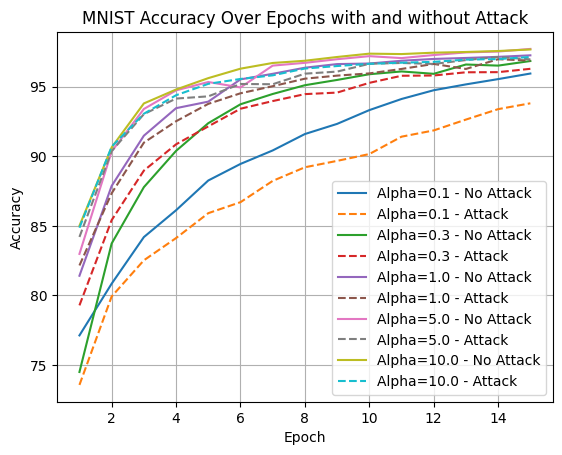

In [12]:
plt.figure()

for alpha in alpha_values:
    epochs = np.arange(1, Epochs + 1)
    plt.plot(
        epochs,
        epoch_results[alpha]["Normal"],
        label=f"Alpha={alpha} - No Attack",
        linestyle="-",
    )
    plt.plot(
        epochs,
        epoch_results[alpha]["Attack"],
        label=f"Alpha={alpha} - Attack",
        linestyle="--",
    )

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MNIST Accuracy Over Epochs with and without Attack")
plt.legend()
plt.grid(True)
plt.savefig("MNIST_Accuracy_Over_Epochs.png")
plt.show()